In [3]:
%load_ext autoreload
%autoreload 2

# Simulating quantum circuits with PyTreeNet

In [4]:
import matplotlib.pyplot as plt

In [5]:
from copy import deepcopy

import numpy as np

from pytreenet.operators.qcircuits import QCircuit
from pytreenet.time_evolution.bug import BUG, BUGConfig
from pytreenet.time_evolution.time_evolution import TimeEvoMode
from pytreenet.special_ttn.mps import MatrixProductState
from pytreenet.operators.models import (local_magnetisation_from_topology,
                                        Topology)

In [6]:
q_prefix = "qubit"
def q_name(n):
    return f"{q_prefix}{n}"

time_step_size = 0.01

## Simple Examples

## Single Qubit Gates

In [7]:
def plot_single_qubit_prob(times, probs):
    fig = plt.figure()
    plt.plot(times, probs)
    plt.xlim((0.0, times[-1]))
    plt.ylim(-1.0,1.0)
    plt.ylabel(r"$\langle \psi | Z_0 | \psi \rangle$")
    plt.xlabel(r"Time $t$")
    plt.show()

from pytreenet.ttns.ttns import TreeTensorNetworkState
from pytreenet.operators.common_operators import ket_i
from pytreenet.core.node import Node
def single_qubit_zero_state() -> TreeTensorNetworkState:
    """Returns a TTN state representing the zero state of a single qubit."""
    ttns = TreeTensorNetworkState()
    tensor = ket_i(0, 2)
    ttns.add_root(Node(identifier=q_name(0)),
                  tensor)
    return ttns

### X-Gate

In [8]:
qc = QCircuit()
qc.add_x(q_name(0))
comp_qc = qc.compile()
mps = single_qubit_zero_state()
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 1, site_prefix=q_prefix)
final_time = 1.0

In [9]:
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)

In [10]:
bug.run()

100%|██████████| 101/101 [00:00<00:00, 1311.08it/s]


In [11]:
results = bug.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)

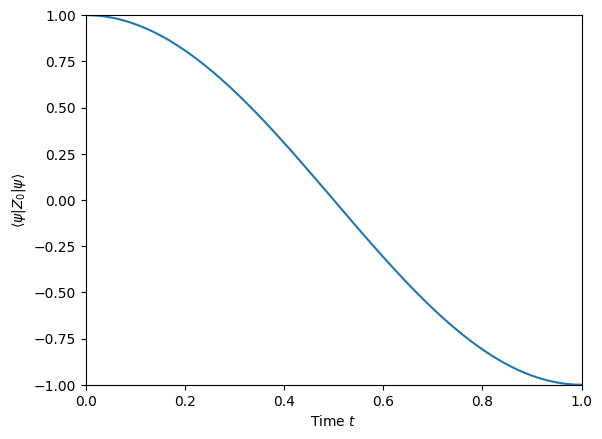

In [12]:
plot_single_qubit_prob(times, prob_0)

In [13]:
correct = np.asarray([0,1], dtype=complex)
print("Overlap Error:", 1 - np.abs(correct.T.conj() @ bug.state.completely_contract_tree()[0]))

Overlap Error: 1.3337442261729393e-11


### Two X-Gates
This should turn the MPS back to its initial state.

In [14]:
qc = QCircuit()
qc.add_x(q_name(0))
qc.add_x(q_name(0),level_index=1)
comp_qc = qc.compile()
mps = single_qubit_zero_state()
ref_mps = deepcopy(mps)
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 1, site_prefix=q_prefix)
final_time = 2.0

In [15]:
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)

In [16]:
bug.run()

100%|██████████| 201/201 [00:00<00:00, 1628.07it/s]


In [17]:
results = bug.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)

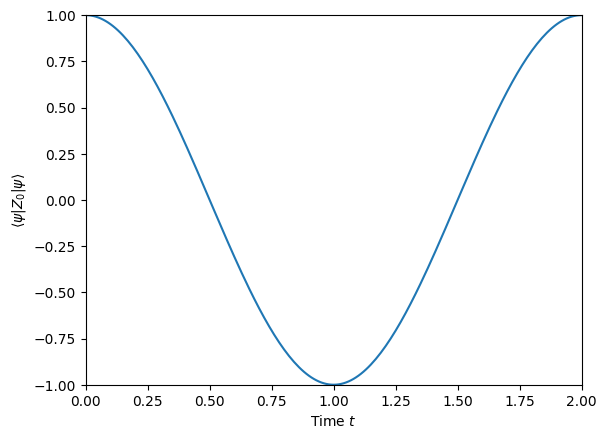

In [18]:
plot_single_qubit_prob(times, prob_0)

In [19]:
print("Overlap error with initial state:", np.abs(1 - np.abs(bug.state.scalar_product(ref_mps))))

Overlap error with initial state: 2.66754396349711e-11


### Hadamard Gate

In [20]:
qc = QCircuit()
qc.add_hadamard(q_name(0))
comp_qc = qc.compile()
mps = single_qubit_zero_state()
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 1, site_prefix=q_prefix)
final_time = 1.0

In [21]:
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug_h0 = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)

In [22]:
bug_h0.run()

100%|██████████| 101/101 [00:00<00:00, 1783.00it/s]


In [23]:
results = bug_h0.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)

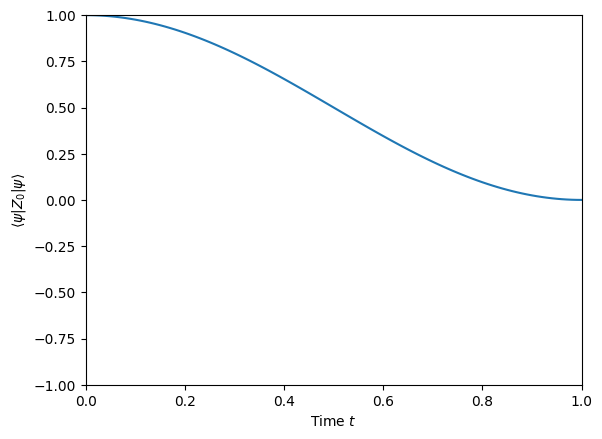

In [24]:
plot_single_qubit_prob(times, prob_0)

In [25]:
correct = (1 / np.sqrt(2) ) * np.asarray([1,1])
found = bug_h0.state.completely_contract_tree()[0]
print("Error in Hadamard state preparation:", np.abs(1 - correct.T.conj() @ found))

Error in Hadamard state preparation: 3.912556626710076e-12


### X and Hadamard

In [26]:
qc = QCircuit()
qc.add_x(q_name(0))
qc.add_hadamard(q_name(0), level_index=1)
comp_qc = qc.compile()
mps = single_qubit_zero_state()
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 1, site_prefix=q_prefix)
final_time = 2.0
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug_h1 = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)
bug_h1.run()
results = bug_h1.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)

100%|██████████| 201/201 [00:00<00:00, 1369.99it/s]


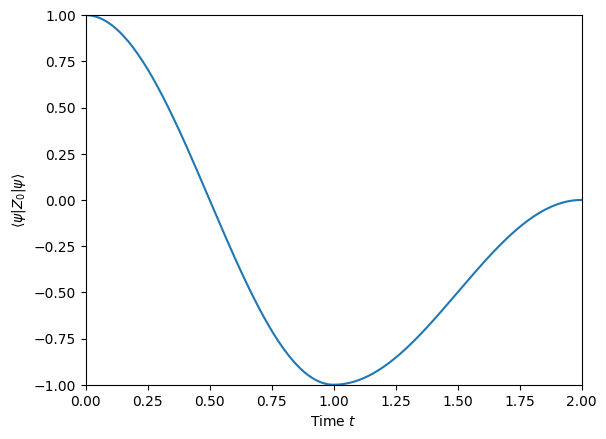

In [27]:
plot_single_qubit_prob(times, prob_0)

The overlap of $H \ket{\psi}$ and $HX \ket{\psi}$ should be zero.

In [28]:
print(bug_h1.state.completely_contract_tree(to_copy=True)[0])
print("Overlap of H and HX:", np.abs(bug_h0.state.scalar_product(bug_h1.state)))

[ 0.70710678+5.08671230e-13j -0.70710678-2.24607138e-12j]
Overlap of H and HX: 3.2207862445592035e-11


### Z and Hadamard Gate

In [29]:
qc = QCircuit()
qc.add_hadamard(q_name(0))
qc.add_z(q_name(0), level_index=1)
comp_qc = qc.compile()
mps = single_qubit_zero_state()
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 1, site_prefix=q_prefix)
final_time = 2.0
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug_h1 = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)
bug_h1.run()
results = bug_h1.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)

100%|██████████| 201/201 [00:00<00:00, 1115.99it/s]


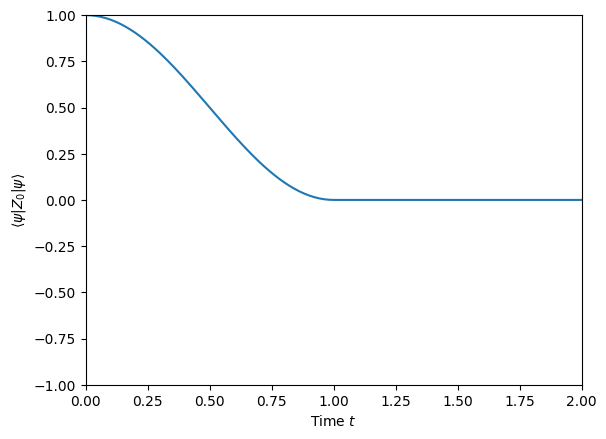

In [30]:
plot_single_qubit_prob(times, prob_0)

## Two Qubit Gates

In [31]:
def two_qubit_zero_state() -> TreeTensorNetworkState:
    """
    Construct the two qubit zero state as a TTNS.
    """
    mps = MatrixProductState.constant_product_state(0,2,2,
                                                    node_prefix=q_prefix,
                                                    bond_dimensions=[2])
    return mps

def plot_two_qubit_prob(times, probs0, probs1):
    fig = plt.figure()
    plt.plot(times, probs0, label=q_name(0))
    plt.plot(times, probs1, label=q_name(1))
    plt.xlim((0.0, times[-1]))
    #plt.ylim(-1.0,1.0)
    plt.ylabel(r"$\langle \psi | Z_0 | \psi \rangle$")
    plt.xlabel(r"Time $t$")
    plt.legend()
    plt.show()


### X and CNOT Gates

In [32]:
qc = QCircuit()
qc.add_x(q_name(0))
qc.add_cnot(q_name(0), q_name(1), level_index=1)
comp_qc = qc.compile()
mps = two_qubit_zero_state()
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 2, site_prefix=q_prefix)
final_time = 2.0
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)
bug.run()
results = bug.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)
prob_1 = results.operator_result(q_name(1), realise=True)

100%|██████████| 201/201 [00:00<00:00, 300.98it/s]


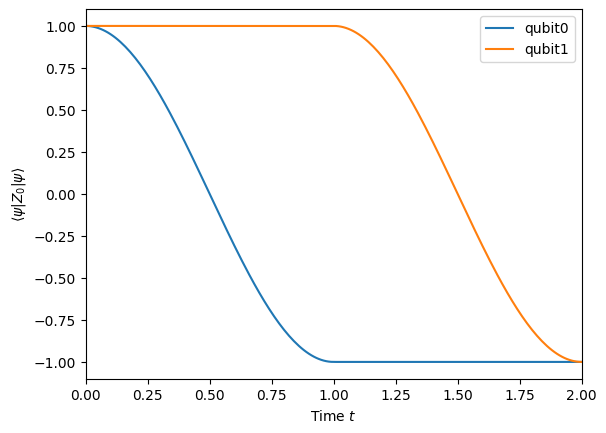

In [33]:
plot_two_qubit_prob(times, prob_0, prob_1)

In [34]:
correct = np.asarray([0,0,0,1])
found = bug.state.completely_contract_tree()[0].reshape((4,))
print("Overlap:", 1 - np.abs(correct.T.conj() @ found))

Overlap: 2.667244203280461e-11


### Hadamard and CNOT
This will produce the Bell state
$$
\beta_{00} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11})
$$

In [35]:
qc = QCircuit()
qc.add_hadamard(q_name(0))
qc.add_cnot(q_name(0), q_name(1), level_index=1)
comp_qc = qc.compile()
mps = two_qubit_zero_state()
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 2, site_prefix=q_prefix)
final_time = 2.0
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)
bug.run()
results = bug.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)
prob_1 = results.operator_result(q_name(1), realise=True)

100%|██████████| 201/201 [00:00<00:00, 248.82it/s]


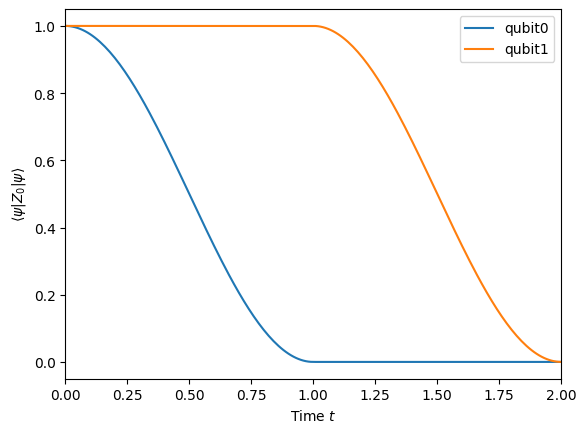

In [36]:
plot_two_qubit_prob(times, prob_0, prob_1)

In [37]:
correct = (1 / np.sqrt(2) ) * np.asarray([1,0,0,1])
found = bug.state.completely_contract_tree()[0].reshape((4,))
print("Overlap:", 1 - np.abs(correct.T.conj() @ found))

Overlap: 1.058342302684423e-11


## Adding a disturbance term
We will now add an additional term to the generator that will cause a move away from the correct simulation.

In [38]:
from fractions import Fraction

from pytreenet.operators.common_operators import pauli_matrices
from pytreenet.operators.hamiltonian import Hamiltonian
from pytreenet.operators.tensorproduct import TensorProduct

In [67]:
qc = QCircuit()
qc.add_hadamard(q_name(0))
qc.add_cnot(q_name(0), q_name(1), level_index=1)
comp_qc = qc.compile()
strength = -100
disturbance = Hamiltonian([(Fraction(1),"s",TensorProduct({q_name(0): "Z", q_name(1): "Z"}))],
                          conversion_dictionary={"Z": pauli_matrices()[0]},
                          coeffs_mapping={"s": strength})
comp_qc.add_hamiltonian(disturbance)
mps = two_qubit_zero_state()
ttno = comp_qc.to_time_dep_ttno(mps)
ops = local_magnetisation_from_topology(Topology.CHAIN, 2, site_prefix=q_prefix)
final_time = 2.0
config = BUGConfig(time_evo_mode=TimeEvoMode.RK45,
                   time_dep=True)
solver_options = {"rtol": 1e-6, "atol": 1e-6}
bug = BUG(mps, ttno, time_step_size, final_time, ops,
          config=config,
          solver_options=solver_options)
bug.run()
results = bug.results
times = results.times()
prob_0 = results.operator_result(q_name(0), realise=True)
prob_1 = results.operator_result(q_name(1), realise=True)

100%|██████████| 201/201 [00:00<00:00, 245.40it/s]


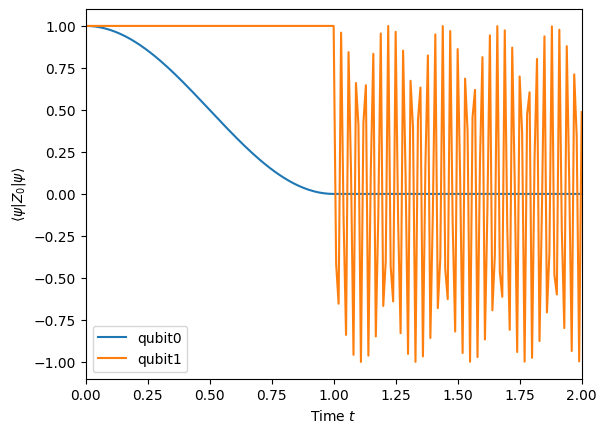

In [68]:
plot_two_qubit_prob(times, prob_0, prob_1)